In [10]:
from numba import cuda
from keras import backend as K

from pymongo import MongoClient
from bson.objectid import ObjectId

import time,datetime
import os

import pandas as pd
import pandas_datareader.data as web
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import style

from keras.models import Model, Sequential
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
import keras
from keras.callbacks import TensorBoard

from sklearn import preprocessing

from copy import deepcopy
from IPython.display import clear_output

In [ ]:
conn = MongoClient('120.126.136.17')
db = conn.Tracker
collection = [db.james]# db.db2, db.dn2, db.james, db.leo
clean_data = []
for col in collection:
    cursor = col.find({})
    df = pd.DataFrame(list(cursor))

<IPython.core.display.Javascript object>


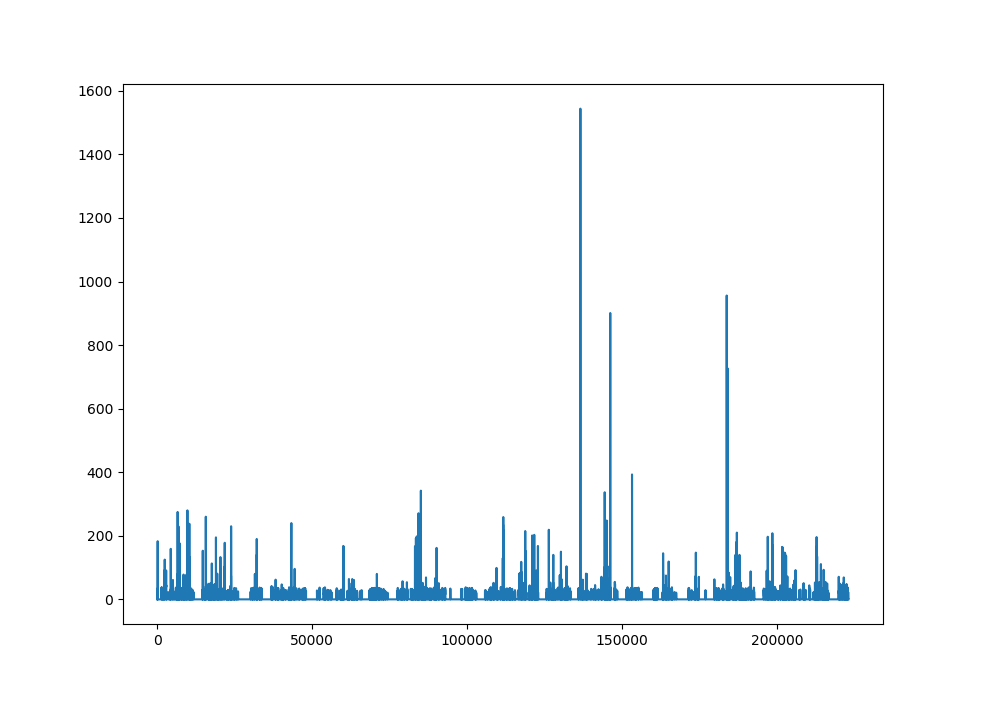

In [9]:
%matplotlib notebook
df['step_value'].plot()

In [12]:
conn = MongoClient('120.126.136.17')
db = conn.Tracker
collection = [db.james]# db.db2, db.dn2, db.james, db.leo
clean_data = []
for col in collection:
    cursor = col.find({})
    df = pd.DataFrame(list(cursor))
df.replace('', np.nan, inplace=True)
df.fillna(method='ffill', inplace=True)

df['hr_value'] = df['hr_value'].astype(float)
df['o2_value'] = df['o2_value'].astype(float)
df['latitude'] = df['latitude'].astype(float)
df['longitude'] = df['longitude'].astype(float)
df['step_value'] = df['step_value'].astype(float)

# map out the weekday
df['weekday'] = df['timestamp'].apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%w'))
df['week'] = df['timestamp'].apply(lambda x: datetime.datetime.fromtimestamp(x).isocalendar()[1]
          - (datetime.datetime.fromtimestamp(x).isoweekday() < 7)) # do this so that week may start on monday

In [13]:
dfstephour = pd.DataFrame({})
dfstephour = df[['week', 'weekday']].set_index(['week', 'weekday'])
dfstephour = dfstephour[~dfstephour.index.duplicated(keep='first')]
dfstephour.reset_index(inplace=True)
# this is where the data have null
dfadd = pd.DataFrame({'week' : [12], 'weekday':['5']})
dfstephour = dfstephour.append(dfadd, ignore_index=True)
dfadd = pd.DataFrame({'week' : [12], 'weekday':['2']})
dfstephour = dfstephour.append(dfadd, ignore_index=True)
dfadd = pd.DataFrame({'week' : [12], 'weekday':['1']})
dfstephour = dfstephour.append(dfadd, ignore_index=True)
dfadd = pd.DataFrame({'week' : [12], 'weekday':['0']})
dfstephour = dfstephour.append(dfadd, ignore_index=True)
dfstephour = dfstephour.set_index(['week', 'weekday'])
dfstephour.sort_index(inplace=True)
for i in range(24):
    dfstephour[i] = 0

In [14]:
# here I map between integer and the sting it's mean
timeslidemap = {0:'msteps', 1:'asteps', 2:'esteps'}
basestamp = df['timestamp'][0]
endstamp = df['timestamp'][-1:].values[0]
# for num, row in df[:30000].iterrows():
while True:
    try:
        hour = datetime.datetime.fromtimestamp(basestamp).hour
        dfbetween = df.loc[df['timestamp'].between(
            datetime.datetime.fromtimestamp(basestamp).replace(hour=hour,minute=0,second=0).timestamp(),
            datetime.datetime.fromtimestamp(basestamp).replace(hour=hour,minute=59,second=59).timestamp()
                    , inclusive=True)]
        steps = dfbetween['step_value'].sum()
    #     print(int(datetime.datetime.fromtimestamp(basestamp).strftime('%m')),
    #             int(datetime.datetime.fromtimestamp(basestamp).strftime('%d')),
    #                 timeslidemap[estimedevide])
    
        dfstephour.loc[[(datetime.datetime.fromtimestamp(basestamp).isocalendar()[1] - 
                                    (datetime.datetime.fromtimestamp(basestamp).isoweekday() < 7),
                            datetime.datetime.fromtimestamp(basestamp).strftime('%w'))], 
                                           [hour]] += steps

        basestamp = (datetime.datetime.fromtimestamp(basestamp) + datetime.timedelta(hours=1)).timestamp()
        if basestamp > endstamp:
            break
    except Exception as e:
#         print(str(e))
        basestamp = (datetime.datetime.fromtimestamp(basestamp) + datetime.timedelta(hours=1)).timestamp()
#     else:
#         print(datetime.datetime.fromtimestamp(basestamp) ,datetime.datetime.fromtimestamp(endstamp))

In [15]:
dfstephour

0     1    2    3    4    5       6       7       8       9   \
week weekday                                                                    
12   0          0.0   0.0  0.0  0.0  0.0  0.0     0.0     0.0     0.0     0.0   
     1          0.0   0.0  0.0  0.0  0.0  0.0     0.0     0.0     0.0     0.0   
     2          0.0   0.0  0.0  0.0  0.0  0.0     0.0     0.0     0.0     0.0   
     3          0.0   0.0  0.0  0.0  0.0  0.0     0.0     0.0     0.0     0.0   
     4          0.0   0.0  0.0  0.0  0.0  0.0     0.0     0.0     0.0     0.0   
     5          0.0   0.0  0.0  0.0  0.0  0.0     0.0     0.0     0.0     0.0   
     6          0.0   0.0  0.0  0.0  0.0  0.0     0.0     0.0     0.0     0.0   
13   0          0.0   0.0  0.0  0.0  0.0  0.0     0.0   320.0     0.0    33.0   
     1          0.0   0.0  0.0  0.0  0.0  0.0     0.0     0.0  2004.0  2347.0   
     2          0.0   0.0  0.0  0.0  0.0  0.0     0.0   248.0   133.0  1036.0   
     3          0.0   0.0  0.0  0.0  0.0  0.0     0.0     0.0   159.0  1018.0   
     4          0.0   0.0  0.0  0.0  0.0  0.0   216.0   283.0    22.0   176.0   
     5          0.0   0.0  0.0  0.0  0.0  0.0     0.0   318.0   318.0     0.0   
     6          0.0   0.0  0.0  0.0  0.0  0.0     0.0     0.0   117.0    28.0   
14   0          0.0   0.0  0.0  0.0  0.0  0.0     0.0   692.0     0.0  1482.0   
     1          0.0   0.0  0.0  0.0  0.0  0.0     0.0   289.0   568.0  1417.0   
     2          0.0   0.0  0.0  0.0  0.0  0.0     0.0     0.0     0.0     0.0   
     3          0.0   0.0  0.0  0.0  0.0  0.0     0.0     0.0   327.0  1178.0   
     4          0.0   0.0  0.0  0.0  0.0  0.0     0.0     0.0    34.0   376.0   
     5          0.0   0.0  0.0  0.0  0.0  0.0     0.0    91.0    61.0   409.0   
     6          0.0   0.0  0.0  0.0  0.0  0.0  1334.0    57.0     0.0    74.0   
15   0          0.0   0.0  0.0  0.0  0.0  0.0     0.0   229.0   770.0  1660.0   
     1          0.0   0.0  0.0  0.0  0.0  0.0  1011.0   100.0  1935.0  3030.0   
     2          0.0   0.0  0.0  0.0  0.0  0.0     0.0     0.0   389.0   325.0   
     3          0.0   0.0  0.0  0.0  0.0  0.0     0.0   298.0   503.0   942.0   
     4          0.0   0.0  0.0  0.0  0.0  0.0     0.0   342.0  1258.0   418.0   
     5          0.0   0.0  0.0  0.0  0.0  0.0     0.0   327.0  1418.0   933.0   
     6          0.0   0.0  0.0  0.0  0.0  0.0     0.0    53.0   732.0     0.0   
16   0          0.0   0.0  0.0  0.0  0.0  0.0     0.0   300.0  1206.0    45.0   
     1          0.0   0.0  0.0  0.0  0.0  0.0     0.0   503.0  2643.0  2402.0   
     2          0.0   0.0  0.0  0.0  0.0  0.0     0.0     0.0     0.0   880.0   
     3          0.0  28.0  0.0  0.0  0.0  0.0     0.0     0.0   182.0   960.0   
     4          0.0   0.0  0.0  0.0  0.0  0.0     0.0     0.0     0.0     0.0   
     5          0.0   0.0  0.0  0.0  0.0  0.0     0.0   205.0     0.0  1952.0   
     6          0.0   0.0  0.0  0.0  0.0  0.0     0.0    23.0   605.0     0.0   
17   0          0.0   0.0  0.0  0.0  0.0  0.0     0.0     0.0  1459.0   102.0   
     1          0.0   0.0  0.0  0.0  0.0  0.0     0.0     0.0     0.0  1845.0   
     2          0.0   0.0  0.0  0.0  0.0  0.0     0.0   255.0   853.0   617.0   
     3          0.0   0.0  0.0  0.0  0.0  0.0     0.0     0.0   694.0   867.0   
     4          0.0   0.0  0.0  0.0  0.0  0.0     0.0     0.0    23.0    89.0   
     5          0.0   0.0  0.0  0.0  0.0  0.0     0.0   636.0    44.0    65.0   
     6         54.0   0.0  0.0  0.0  0.0  0.0     0.0     0.0     0.0   205.0   
18   0          0.0   0.0  0.0  0.0  0.0  0.0     0.0  1259.0    29.0     0.0   
     1          0.0   0.0  0.0  0.0  0.0  0.0     0.0     0.0  2145.0  4173.0   
     2          0.0   0.0  0.0  0.0  0.0  0.0     0.0     0.0  1082.0   956.0   
     3         21.0   0.0  0.0  0.0  0.0  0.0     0.0     0.0   749.0   597.0   
     4          0.0   0.0  0.0  0.0  0.0  0.0     0.0     0.0     0.0   951.0   
     5          0.0   0.0  0.0  0.0  0.0  0.0   

<IPython.core.display.Javascript object>


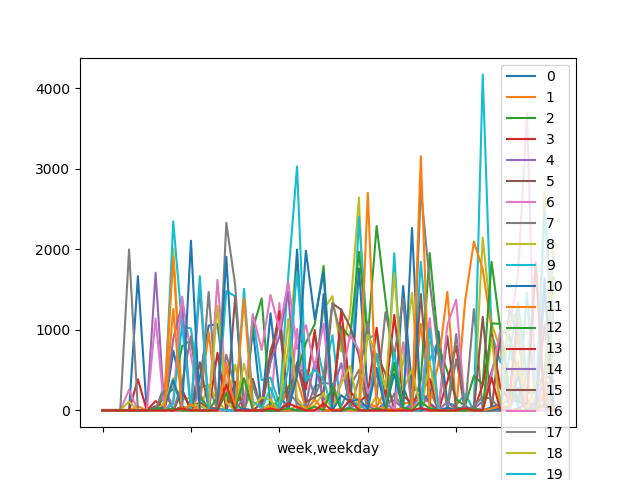

In [34]:
dfstephour.plot()